In [1]:
#------------------------------------------------------------------------------------
# 파일을 synap 문서필터로 Text 추출하여 저장한 파일들을 불러와서 , 문장 클러스터링 임베딩 벡터를 구하고, Faiss 를 이용하여 MRR와 검색률 구하는 예제
# -> 사이냅(synap) 문서필터를 이용하여 문서에서 text 추출하여 파일로저장한 문서를 이용.
# -> 쿼리는 문서 제목을 이용하여 정확도 측정함.
# -> 문장 클러스터링을 위해 문장들은 KSS를 이용하여 먼저 나누고, 다시 '\n'로 구분되는 문장들로 나누어 임베딩 구함.
# -> 문장들 임베딩 구하고 나서는 유사한 문장들을 클러스터링 함.
#------------------------------------------------------------------------------------

import faiss
import numpy as np
import pandas as pd
import time
import os

from os import sys
sys.path.append('../')
from myutils import GPU_info, seed_everything, mlogging, bi_encoder

logger = mlogging(loggername="test", logfilename="../../log/test")
device = GPU_info()
#device = 'cpu'  # cpu 테스트 할때

#------------------------------------------------------------------------------------
# 0. param 설정
#------------------------------------------------------------------------------------
seed = 111
query_num = 0               # 쿼리 최대 갯수: KorQuAD_v1.0_dev.json 최대값은 5533개임, 0이면 모든 5533개 쿼리함.
search_k = 5                # FAISS 검색시, 검색 계수(5=쿼리와 가장 근접한 5개 결과값을 반환함)
avg_num = 1                 # 쿼리에 대해 sub 문장들중 최대 scorce를 갖는 문장을 몇개 찾고 평균낼지.(3=쿼리에 가장 유사한 sub문장 3개를 찾고 평균을 냄)
faiss_index_method = 0      # 0= Cosine Similarity 적용(IndexFlatIP 사용), 1= Euclidean Distance 적용(IndexFlatL2 사용)

# 임베딩 방식 (0=문장클러스터링, 1=문장평균임베딩, 2=문장임베딩)
EMBEDDING_METHOD = 0        

# 청크 분할 혹은 슬라이딩 윈도우param
IS_SLIDING_WINDOW = False
WINDOW_SIZE=256             # 문단을 몇 token으로 나눌지          (128,0)=>78.40%, (256, 64)=>75.20%
SLIDING_SIZE=0              # 중첩되는 token 

# 클러스트링 param
CLUSTRING_MODE = "kmeans"  # "kmeans" = k-평균 군집 분석, kmedoids =  k-대표값 군집 분석
num_clusters = 7           # 클러스터링 계수 
outmode = "mean"           # 클러스터링후 출력벡터 정의(kmeans 일때 => mean=평균벡터 출력, max=최대값벡터출력 / kmedoids 일때=>mean=평균벡터, medoid=대표값벡터)

# ONNX 모델 사용 유.무
IS_ONNX_MODEL = False

# 차원 축소
out_dimension = 128  # 768은 0으로 입력, 128=128 입력

# 문장 전처리
remove_sentence_len = 8    # 문장 길이가 10이하면 제거 
remove_duplication = False # 중복된 문장 제거(*중복된 문장 제거 안할때 1%정도 정확도 좋음)

use_bm25 = False           # BM25 출력 할지=True. 안할지=False
#------------------------------------------------------------------------------------

seed_everything(seed)

logfilepath:../../log/test_2023-04-07.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
# 문장 분할 테스트
'''
from myutils import split_sentences, get_text_chunks

contexts = [
'

6. SQL, SQL*Plus 기본 - SELECT
SELECT * FROM emp;
SELECT empno, ename, job, sal FROM emp;
SELECT empno, ename, sal* 12 FROM emp;
SELECT empno, ename, sal* 12 "ANNUAL SAL" FROM emp;
SELECT empno, ename, TO_CHAR(sal* 12, '999,999') "ANNUAL SAL" FROM emp;
SELECT empno, ename FROM empWHERE empno= 7369;
SELECT empno, ename, sal FROM empWHERE JOB = 'SALESMAN' AND sal> 1300;
SELECT * FROM empWHERE hiredateBETWEEN '81/01/01' AND '81/12/31';
SELECT * FROM empWHERE hiredateBETWEEN '81/01/01' AND '81/12/31' ORDER BY hiredate;
'
]

doc_sentences = split_sentences(paragraphs=contexts, remove_line=False, remove_sentence_len=8, remove_duplication=False, sentences_split_num=10000, paragraphs_num=10000000, showprogressbar=True, debug=False)
print(doc_sentences)
'''

'\nfrom myutils import split_sentences, get_text_chunks\n\ncontexts = [\n\'\n\n6. SQL, SQL*Plus 기본 - SELECT\nSELECT * FROM emp;\nSELECT empno, ename, job, sal FROM emp;\nSELECT empno, ename, sal* 12 FROM emp;\nSELECT empno, ename, sal* 12 "ANNUAL SAL" FROM emp;\nSELECT empno, ename, TO_CHAR(sal* 12, \'999,999\') "ANNUAL SAL" FROM emp;\nSELECT empno, ename FROM empWHERE empno= 7369;\nSELECT empno, ename, sal FROM empWHERE JOB = \'SALESMAN\' AND sal> 1300;\nSELECT * FROM empWHERE hiredateBETWEEN \'81/01/01\' AND \'81/12/31\';\nSELECT * FROM empWHERE hiredateBETWEEN \'81/01/01\' AND \'81/12/31\' ORDER BY hiredate;\n\'\n]\n\ndoc_sentences = split_sentences(paragraphs=contexts, remove_line=False, remove_sentence_len=8, remove_duplication=False, sentences_split_num=10000, paragraphs_num=10000000, showprogressbar=True, debug=False)\nprint(doc_sentences)\n'

In [3]:
'''
#------------------------------------------------------------------
# MpowerAI 문서필터를 이용하여 문서에서 TEXT 추출후 파일로 저장
#------------------------------------------------------------------

from os import sys
sys.path.append('../../MpowerAI')
from pympower.classes.mshaai import MShaAI

from myutils import getListOfFiles
from tqdm.notebook import tqdm

DATA_FOLDER = '../../data11/mpower_doc/11/'  # 추출할 문서들이 있는 경로
OUT_FOLDER = '../../data11/mpower_doc/out-11/'  # text 추출후 저장될 폴더

if not os.path.exists(OUT_FOLDER):
    os.makedirs(OUT_FOLDER)
    
shaai = MShaAI()

file_paths = getListOfFiles(DATA_FOLDER)
assert len(file_paths) > 0 # files가 0이면 assert 발생
print('*file_count: {}, file_list:{}'.format(len(file_paths), file_paths[0:5]))

for idx, file_path in enumerate(tqdm(file_paths)):
    if '.ipynb_checkpoints' not in file_path:
        srcPath = file_path
        file_name = os.path.basename(file_path)+'.txt'  # 파일명만 뽑아냄
        tgtPath = OUT_FOLDER + file_name
        print(srcPath)
        shaai.extract(srcPath=srcPath, tgtPath=tgtPath)
        
        #with open(tgtPath, 'r', encoding='utf-8') as f:
        #    print(f.read())
'''

"\n#------------------------------------------------------------------\n# MpowerAI 문서필터를 이용하여 문서에서 TEXT 추출후 파일로 저장\n#------------------------------------------------------------------\n\nfrom os import sys\nsys.path.append('../../MpowerAI')\nfrom pympower.classes.mshaai import MShaAI\n\nfrom myutils import getListOfFiles\nfrom tqdm.notebook import tqdm\n\nDATA_FOLDER = '../../data11/mpower_doc/11/'  # 추출할 문서들이 있는 경로\nOUT_FOLDER = '../../data11/mpower_doc/out-11/'  # text 추출후 저장될 폴더\n\nif not os.path.exists(OUT_FOLDER):\n    os.makedirs(OUT_FOLDER)\n    \nshaai = MShaAI()\n\nfile_paths = getListOfFiles(DATA_FOLDER)\nassert len(file_paths) > 0 # files가 0이면 assert 발생\nprint('*file_count: {}, file_list:{}'.format(len(file_paths), file_paths[0:5]))\n\nfor idx, file_path in enumerate(tqdm(file_paths)):\n    if '.ipynb_checkpoints' not in file_path:\n        srcPath = file_path\n        file_name = os.path.basename(file_path)+'.txt'  # 파일명만 뽑아냄\n        tgtPath = OUT_FOLDER + file_name\n     

In [4]:

#------------------------------------------------------------------
# 추출된 문서 TEXT들을 전처리(한글,영문,숫자 이외 제거) 후, 문장으로 분리 후 파일로 저장
#------------------------------------------------------------------
'''
import kss
IN_FOLDER = '../../data11/mpower_doc/out/'
OUT_FOLDER = '../../data11/mpower_doc/out-sentence/'

if not os.path.exists(OUT_FOLDER):
    os.makedirs(OUT_FOLDER)

# json 파일들이 있는 폴더에 .json 파일 이름들을 얻기
# =>DATA_FOLDER: .JSON파일들이 있는 폴더
file_paths = getListOfFiles(IN_FOLDER)
assert len(file_paths) > 0 # files가 0이면 assert 발생
    
print('*file_count: {}, file_list:{}'.format(len(file_paths), file_paths[0:5]))

file_name_list = []

for idx, file_path in enumerate(tqdm(file_paths)):
    if '.ipynb_checkpoints' not in file_path:
        sentences = []
        with open(file_path, 'r', encoding='utf-8') as f:
            data = f.read()
            
            data = data.replace('\n', ' ').replace('\r', ' ') # 띄어쓰기 제거
            data = clean_text(data) # 한글, 영문, 숫자 이외 제거 
            
            for sentence in kss.split_sentences(data):
                if sentence != '' and len(sentence) > 5:
                    for sentence1 in kss.split_sentences(sentence): # 한번더 돌림
                         if sentence1 != '' and len(sentence1) > 5: 
                            sentences.append(sentence1)
             
            print(f'{file_path} : 문장 수 : {len(sentences)}')
            print()
            
            # 파일로저장
            file_name = os.path.basename(file_path)  # 파일명만 뽑아냄
            file_name_list.append(file_name)
            
            output_file = OUT_FOLDER + file_name
            with open(output_file, 'w', encoding='utf-8') as f:
                for ss in sentences:
                    f.write(ss+'\n')
'''

"\nimport kss\nIN_FOLDER = '../../data11/mpower_doc/out/'\nOUT_FOLDER = '../../data11/mpower_doc/out-sentence/'\n\nif not os.path.exists(OUT_FOLDER):\n    os.makedirs(OUT_FOLDER)\n\n# json 파일들이 있는 폴더에 .json 파일 이름들을 얻기\n# =>DATA_FOLDER: .JSON파일들이 있는 폴더\nfile_paths = getListOfFiles(IN_FOLDER)\nassert len(file_paths) > 0 # files가 0이면 assert 발생\n    \nprint('*file_count: {}, file_list:{}'.format(len(file_paths), file_paths[0:5]))\n\nfile_name_list = []\n\nfor idx, file_path in enumerate(tqdm(file_paths)):\n    if '.ipynb_checkpoints' not in file_path:\n        sentences = []\n        with open(file_path, 'r', encoding='utf-8') as f:\n            data = f.read()\n            \n            data = data.replace('\n', ' ').replace('\r', ' ') # 띄어쓰기 제거\n            data = clean_text(data) # 한글, 영문, 숫자 이외 제거 \n            \n            for sentence in kss.split_sentences(data):\n                if sentence != '' and len(sentence) > 5:\n                    for sentence1 in kss.split_sentences(sent

In [5]:
#-------------------------------------------------------------------------------------
# 1. 검색모델 로딩
# => bi_encoder 모델 로딩, polling_mode 설정
# => bi_encoder1 = SentenceTransformer(bi_encoder_path) # 오히려 성능 떨어짐. 이유는 do_lower_case나, max_seq_len등 세부 설정이 안되므로.
#-------------------------------------------------------------------------------------
import torch
from myutils import bi_encoder, dense_model, onnx_model, onnx_embed_text
from sentence_transformers import SentenceTransformer

#bi_encoder_path = "../../data11/model/bert/moco-sentencebertV2.0-nli_128d-sts" 
bi_encoder_path = "bongsoo/kpf-sbert-128d-v1" #"bongsoo/kpf-sbert-v1.1" # kpf-sbert-v1.1 # klue-sbert-v1 # albert-small-kor-sbert-v1.1
pooling_mode = 'mean' # bert면=mean, albert면 = cls


word_embedding_model1, bi_encoder1 = bi_encoder(model_path=bi_encoder_path, max_seq_len=512, do_lower_case=True, 
                                              pooling_mode=pooling_mode, out_dimension=out_dimension, device=device)
  
print(f'\n---bi_encoder---------------------------')
print(bi_encoder1)
print(word_embedding_model1)
#------------------------------------------------------------------------------------------------------------------------


---bi_encoder---------------------------
SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 128, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)
Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 


In [6]:
from myutils import remove_reverse, getListOfFiles, clean_text
from tqdm.notebook import tqdm

# 문서 추출된 TEXT들을 dataframe 형태로 만듬.
OUT_FOLDER = '../../data11/mpower_doc/out/' # 추출된 TEXT 파일들이 있는 루트폴더

# OUT_FOLDER에 모든 파일 경로를 얻어옴.
file_paths = getListOfFiles(OUT_FOLDER)
assert len(file_paths) > 0 # files가 0이면 assert 발생
    
print('*file_count: {}, file_list:{}'.format(len(file_paths), file_paths[0:5]))

contexts = []
titles = []
contextids = []

# TEXT 추출된 파일들을 읽어오면서 제목(title), 내용(contexts) 등을 저장해 둠.
contextid = 1000
for idx, file_path in enumerate(tqdm(file_paths)):
    if '.ipynb_checkpoints' not in file_path:
        sentences = []
        with open(file_path, 'r', encoding='utf-8') as f:
            data = f.read()
            
            #.PAGE:1 패턴을 가지는 문장은 제거함.
            pattern = r"\.\.PAGE:\d+\s?"
            data = clean_text(text=data, pattern=pattern)
            
            file_name = os.path.basename(file_path)  # 파일명만 뽑아냄
            
            #  filename = 5.보안사업부 사업계획.hwp.txt 이면 뒤에 hwp.txt는 제거하고 '5.보안사업부 사업계획' 문자열만 title로 저장함.
            file_name = remove_reverse(file_name, '.')# 5.보안사업부 사업계획.hwp 출력됨
            file_name = remove_reverse(file_name, '.')# 5.보안사업부 사업계획 출력됨
            
            contextid += 1
            contexts.append(data)     # 파일 내용 저장 
            titles.append(file_name)  # 파일명을 제목으로 저장(추후 쿼리할 문장이 됨)
            contextids.append(contextid) # contextid 저장 
 
# 데이터 프레임으로 만듬.
df_contexts = pd.DataFrame((zip(contexts, contextids)), columns = ['context','contextid'])
df_questions = pd.DataFrame((zip(titles, contextids)), columns = ['question','contextid'])

print(f'*len(contexts): {len(contexts)}')

*file_count: 302, file_list:['../../data11/mpower_doc/out/9/Autotools를 이용한 리눅스 응용프로그램 빌드.pptx.txt', '../../data11/mpower_doc/out/9/Apache에서 Tomcat 사용하기.htm.txt', '../../data11/mpower_doc/out/9/BERT 모델 STS 성능 비교분석.pptx.txt', '../../data11/mpower_doc/out/9/클라우드서비스 구축 신청서.hwp.txt', '../../data11/mpower_doc/out/9/클라우드서비스 보안인증제 운영 변경관리서.hwp.txt']


  0%|          | 0/302 [00:00<?, ?it/s]

*len(contexts): 253


In [7]:
df_contexts.head()

,context,contextid
0,A2utoto12ols를 이용한\n리눅스 응용 프로그램 빌드\n201년 보안사업부/...,1001
1,Apache에서 Tomcat 사용하기\n요약\nTomcat은 Java Servlet...,1002
2,BERT 모델 STS 성능 비교 분석\n2022-12\nBERT 모델 개요\n다양한...,1003
3,클라우드서비스 구축 신청서\n신청인\n업체명 : \n사업자등록번호 : \n주소 : ...,1004
4,클라우드서비스 보안인증제 운영 변경관리서\n2021. 12.\n■ 문서이력\n개정일...,1005


In [8]:
df_questions.tail()

,question,contextid
248,청탁금지법_Q&A_사례집[1],1249
249,최근 해킹사고 분석 및 대응방안,1250
250,출퇴근 관리 시스템 도입에 따른 근무 관련 메뉴얼,1251
251,침입탐지시스템 기술 및 시장동향,1252
252,침입탐지시스템,1253


In [9]:
#-------------------------------------------------------------------------------------------------------
# 3. 슬라이딩 윈도우 혹은 문장 분리  
# 1) 슬라이딩 윈도우 : 문장(문서)들을 chunk(청크: 큰 덩어리)로 분리, 다시 분리된 chunks를 kss로 문장 분리해서 sentences 만듬, 이후 chunks와 sentences를 doc_sentences에 담음
#    최대 512 단위로 서로 겹치게 청크 단위로 분리함.
# 2) 문장 분리 : kss와 \n(줄바꿈)으로 문장을 분리함.
#-------------------------------------------------------------------------------------------------------
from myutils import sliding_window_tokenizer, split_sentences, get_text_chunks

#text = ["해외에서 데이터 무제한?? 뿐 아니라 음성과 문자 요금을 할인 받을 수 있는 ++요금제가 나왔다. 날씨는 좋다. lg유플러스는 중국, 일본, 홍콩, 싱가포르, 필리핀 등 아시아 8국을 대상으로~~ 무제한 데이터와 음성, 문자를 할인해주는 '스마트 로밍 요금제' 2종을 오는 28일부터 판매한다고 27일 밝혔다. . . 우선 '스마트 로밍음성'은 하루 기본료가 2000원으로 음성발신은 1분당 1000원이며, 문자메시지(sms)와 멀티미디어 문자메시지(mms)는 1건당 150원이다. 종전 500원에서 350원 인하했다. . . '스마트 로밍패키지'는 여기에 데이터 무제한 로밍서비스가 더해져 하루 기본료가 1만1000원이다. 기본료는 로밍 기간에 상관없이 사용한 당일에만 청구된다. . . 스마트 로밍 요금제는 일단 오는 7월 말까지 프로모션 형태로 제공하고 이후 정식 요금제로 추진한다는 계획이다. . . 아울러 해외에서 무제한 데이터 로밍 서비스와 데이터로밍 차단을 신청·해지할 수 있는 로밍 전용 모바일 홈페이지((이메일))도 운영한다. . . (이름) lg유플러스 글로벌로밍팀장은 '아시아 출(이름) 여행을 계획하고 있는 고객들이 저렴한 비용으로 안심하고 로밍 서비스를 사용할 수 있도록 이번 프로모션 요금제를 출시했다'며 '지속적으로 해외 로밍 이용 고객들의 편의성 증대를 위한상품을 준비할 예정'이라고 말했다. . . . . . . . # # #. . ■ 사진설명. . lg유플러스(부회장 (이름) / (이메일) )가 4월 28일부터 중국, 일본 등 아시아 8개국*을 대상으로 데이터와 음성 문자까지 할인해서 제공하는 스마트 로밍요금제(스마트 로밍음성/스마트 로밍패키지) 2종을 출시했다."]
#text =["오늘은 날씨가 ^^~~~~좋다. 내일은 비가 오고 춥겠다고 한다^^. 걱정이다. 오늘만큼만 매일 날씨가 좋으면 좋겠다.~~~~"]
contexts = df_contexts['context'].values.tolist()
start = time.time()


doc_sentences = []
tokenizer = word_embedding_model1.tokenizer
    
# 슬라이딩 윈도우 처리 후 chunks 리스트 만들고, 다시 chunks를 kss로 문장 분리해서, 최종 chunks와 sentences를 doc_sentences에 담음
if IS_SLIDING_WINDOW == True:
    for idx, context in enumerate(tqdm(contexts)):
        
        clean_context = clean_text(context)  # 전처리 : (한글, 숫자, 영문, (), {}, [], %, ,,.,",')  등을 제외한 특수문자 제거
        
        pattern = r'^\d+(\.\d+)*'  # 문장 맨앞에 '4.1.2.3' 패턴 제거,  r'^\d+(\.\d+)*\s+' # 문장 맨앞에 '4.1.2.3띄어쓰기' 있는 패턴 제거
        clean_context = clean_text(text=clean_context, pattern=pattern)
                        
        pattern = r'^\d+\.'  # 문장 맨 앞에 '4.' 패턴 제거
        clean_context = clean_text(text=clean_context, pattern=pattern)
                        
        pattern = r'^\d+\)'  # 문장 맨 앞에 '4)' 패턴 제거
        clean_context = clean_text(text=clean_context, pattern=pattern)
         
              
        #chunks = sliding_window_tokenizer(tokenizer = tokenizer, paragraph=clean_context, window_size=WINDOW_SIZE, sliding_size=SLIDING_SIZE)
        
        # 청크 클러스터링만 수행함
        chunks = get_text_chunks(tokenizer = tokenizer, paragraph=clean_context, chunk_token_size=WINDOW_SIZE)
        doc_sentences.append(chunks)
        
        #sentences = split_sentences(paragraphs=chunks, remove_line=False, remove_sentence_len=remove_sentence_len, sentences_split_num=10000, paragraphs_num=10000000, debug=False)

        # chunks 1차원 리스트[A,B,C]와 sentences 2차원 리스트[[a,b],[b,c],[d,e]] 를 합쳐서, doc_sentencs[A,a,b,B,b,c,C,d,e] 에 담음.
        #arr = []
        #[arr.extend([chunks[i], *sentences[i]]) for i in range(len(chunks))]

        # doc_sentences 리스트에 추가 
        #doc_sentences.append(arr)
        
# 문장 분리해서 doc_sentences에 담음.
else:
    doc_sentences = split_sentences(paragraphs=contexts, 
                                    remove_line=False, 
                                    remove_sentence_len=remove_sentence_len, 
                                    remove_duplication=remove_duplication, 
                                    check_en_ko=False, # 한국어 혹은 영어문장이외 제거하면, 즉 true 지정하면 1% 성능 저하됨
                                    sentences_split_num=10000, paragraphs_num=10000000, showprogressbar=True, debug=False)

logger.info(f'*문장처리=>len:{len(doc_sentences[0])}, time:{time.time()-start:.4f}')

len_list = []
for i, doc_sentence in enumerate(doc_sentences):
    doc_sentence_len = len(doc_sentence)
    print(f'[{i}] {doc_sentence_len}/{df_questions["question"][i]}')
    len_list.append(doc_sentence_len)
    
logger.info(f'*문장 길이=>평균:{sum(len_list) / len(len_list)} / MAX: {max(len_list)} / MIN: {min(len_list)}')

  0%|          | 0/253 [00:00<?, ?it/s][Kss]: Oh! You have konlpy.tag.Mecab in your environment. Kss will take this as a backend! :D

100%|██████████| 253/253 [01:46<00:00,  2.38it/s]
2023-04-07 15:49:50,115 - test - INFO - *문장처리=>len:442, time:106.4240
[Kss]: *문장처리=>len:442, time:106.4240
2023-04-07 15:49:50,122 - test - INFO - *문장 길이=>평균:339.501976284585 / MAX: 7909 / MIN: 1
[Kss]: *문장 길이=>평균:339.501976284585 / MAX: 7909 / MIN: 1


[0] 442/Autotools를 이용한 리눅스 응용프로그램 빌드
[1] 207/Apache에서 Tomcat 사용하기
[2] 120/BERT 모델 STS 성능 비교분석
[3] 19/클라우드서비스 구축 신청서
[4] 233/클라우드서비스 보안인증제 운영 변경관리서
[5] 78/회사 직원 급여관련 규정
[6] 217/BERT 검색 , 분류 시스템 성능 측정
[7] 268/테이블 데이터 조회하는 방법
[8] 7909/클라우드_취약점_점검_가이드(up)
[9] 225/회사 채용,승진,퇴사관련 인사규정
[10] 42/컨텍스트 메뉴를 통한 반출 개선
[11] 28/행정 전자 서명 인증 표준 API 이용을 위한 신청서 양식
[12] 3856/행정전자서명인증 표준보안 개발자가이드
[13] 248/BERT Distillation with Catalyst. How to distill BERT with Catalyst-PyTorch _ Medium
[14] 189/침입탐지시스템(IDS)  개론(1)
[15] 66/행정기관 및 공공기관의 클라우드컴퓨팅서비스 이용 기준 및 안전성 확보 등에 관한 고시(행정안전부고시)
[16] 251/BERT 기반 애플리케이션을 위한 팁과 요령
[17] 215/커맨드에서 소스 세이프 사용하는 방법
[18] 177/코로나19예방 및 확산방지를 위한 사회적 거리두기 지침(2단계, 사업장
[19] 671/G드라이브 운영자지침서
[20] 394/Dictionary 활용
[21] 205/BERT를 활용한 문서검색모델 구성방안 및 테스트
[22] 233/Distillation of BERT
[23] 90/BERT Single Sentence Classification Fine-Tuning 테스트
[24] 102/IaaS 유망 기업 모집 관련 문서
[25] 55/G드라이브 고도화 - V10 버전과 기능 비교_v1.0
[26] 128/ElasticSearch 클러스터 구성
[27] 59/ESXi 서버 설정 매뉴얼
[28] 172/Java 알고리즘 Provider 추

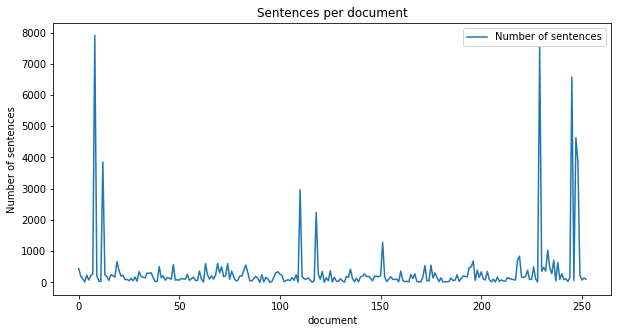

In [10]:
# 2D 그래프로 문서의 임베딩된 문장 계수를 보여줌
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'Number of sentences': len_list})
df.plot(kind='line', figsize=(10,5))
plt.xlabel('document')
plt.ylabel('Number of sentences')
plt.title('Sentences per document')
plt.show()

Text(0, 0.5, 'Count')

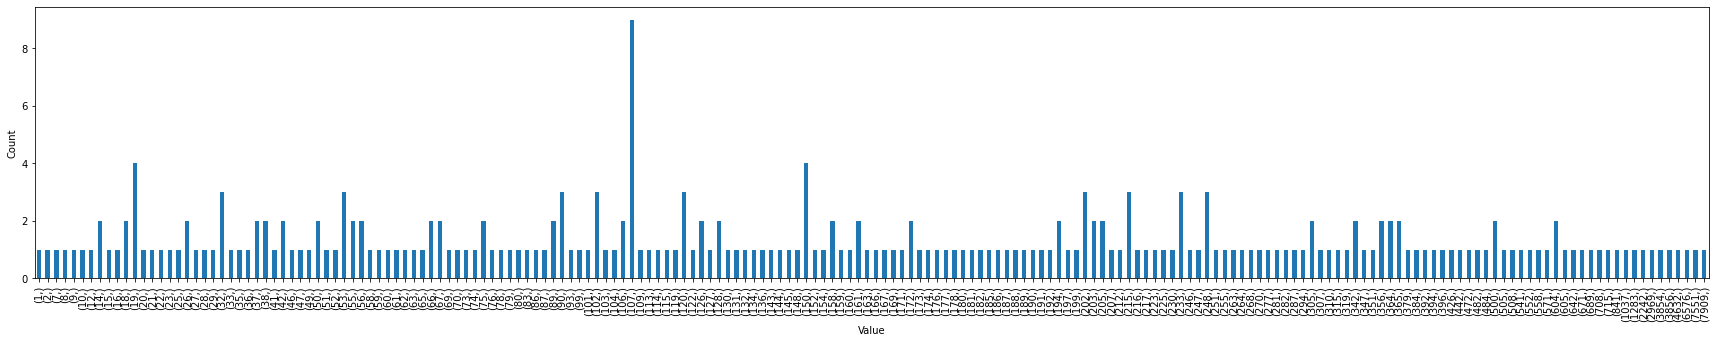

In [11]:
# 임베딩된 문장 계수를 bar 그래프로 보여줌.
import pandas as pd
value_counts = pd.DataFrame(len_list, columns=['values']).value_counts().sort_index()

# kind='bar'
ax = value_counts.plot(kind='bar', x=value_counts.index, y='values', legend=False, figsize=(30,5))
ax.set_xlabel("Value")
ax.set_ylabel("Count")


*range_len: 263
*max_len: 7909

range----------------------------
[(0, 262), (263, 525), (526, 788), (789, 1051), (1052, 1314), (1315, 1577), (1578, 1840), (1841, 2103), (2104, 2366), (2367, 2629), (2630, 2892), (2893, 3155), (3156, 3418), (3419, 3681), (3682, 3944), (3945, 4207), (4208, 4470), (4471, 4733), (4734, 4996), (4997, 5259), (5260, 5522), (5523, 5785), (5786, 6048), (6049, 6311), (6312, 6574), (6575, 6837), (6838, 7100), (7101, 7363), (7364, 7626), (7627, 7889), (7890, 7909)]


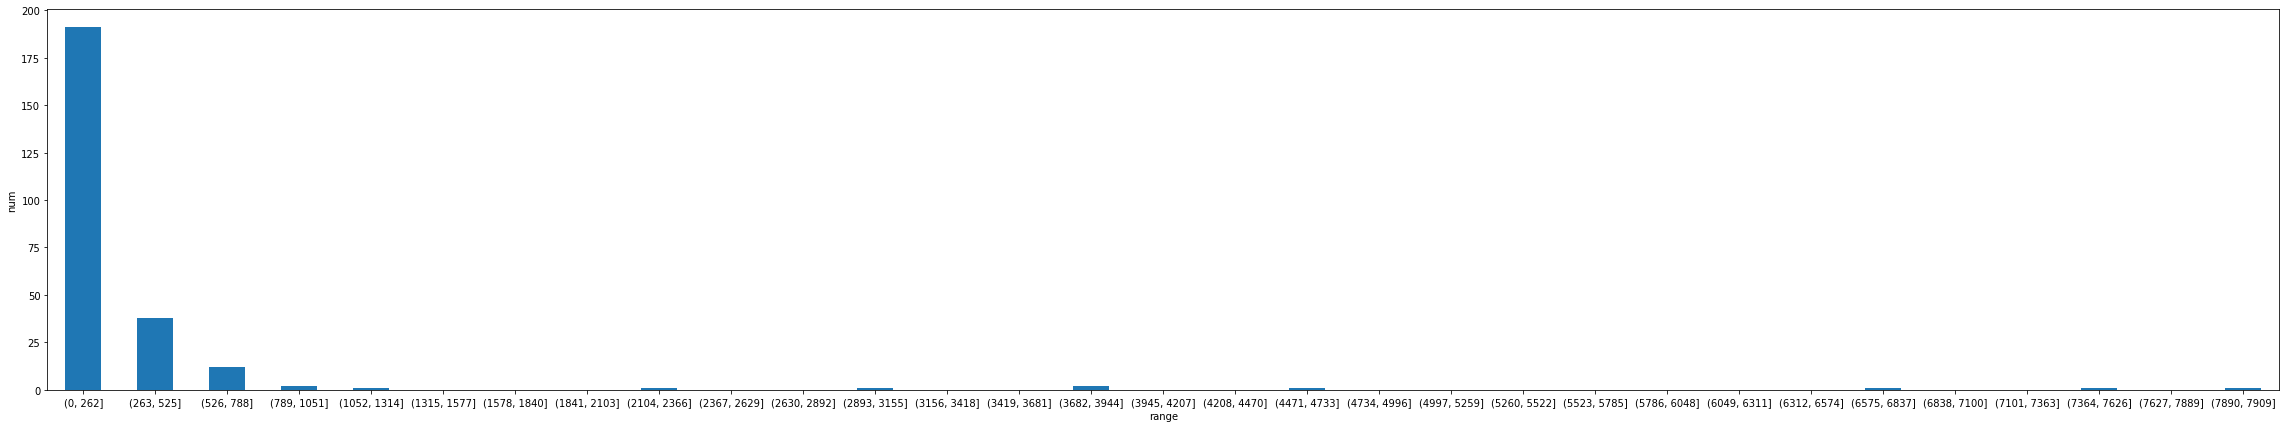

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1부터 8000까지 값을 가지는 랜덤한 250개의 숫자를 생성합니다.
#random_nums = pd.Series(np.random.randint(1, 8000, 250))

# 리스트를 저장할 빈 리스트를 생성합니다.
result = []

# 0부터 8000까지 500씩 증가하는 범위를 생성하고 반복합니다.
max_len = max(len_list)
range_len = int(max_len//30)
print(f'*range_len: {range_len}')
print(f'*max_len: {max_len}')
for i in range(0, max_len, range_len):
    # 현재 범위의 시작과 끝 값을 구합니다.
    start = i
    end = i + (range_len-1)
    
    # 만약 끝 값이 8000을 초과하면, 8000으로 설정합니다.
    if end > max_len:
        end = max_len
    
    # 시작과 끝 값을 튜플로 묶어 리스트에 추가합니다.
    result.append((start, end))

# 결과를 출력합니다.
print()
print(f'range----------------------------')
print(result)

# 0~100, 101~200, 201~300 까지 값을 가지는 구간을 정의합니다.
ranges = pd.IntervalIndex.from_tuples(result)

# 각 구간에 해당하는 숫자의 개수를 구합니다.
counts = pd.cut(len_list, ranges).value_counts().sort_index()

# 결과를 그래프로 출력합니다.
ax = counts.plot(kind='bar', rot=0, figsize=(40,7))
ax.set_xlabel('range')
ax.set_ylabel('num')
plt.show()


In [13]:
from myutils import embed_text, onnx_embed_text

# 조건에 맞게 임베딩 처리하는 함수 
def embedding(paragrphs:list):
    if IS_ONNX_MODEL == True:
        embeddings = onnx_embed_text(model=onnx_model, tokenizer=onnx_tokenizer, paragraphs=paragrphs, token_embeddings=False)
    else:
        # 한 문단에 대한 40개 문장 배열들을 한꺼번에 임베딩 처리함
        embeddings = embed_text(model=bi_encoder1, paragraphs=paragrphs, return_tensor=False)  
    
    return embeddings

In [14]:
# 분리된 문장들에 대해 클러스터링 실행
#-------------------------------------------------------------------------------------------------------
#문단에 문장들의 임베딩을 구하여 각각 클러스터링 처리함.
#-------------------------------------------------------------------------------------------------------
# Then, we perform k-means clustering using sklearn:
from sklearn.cluster import KMeans
from myutils import embed_text, fassi_index, clustering_embedding, kmedoids_clustering_embedding

#클러스터링 계수는 문단의 계수보다는 커야 함. 
assert num_clusters <= len(doc_sentences), f"num_clusters:{num_clusters} > len(doc_sentences):{len(doc_sentences)}"

start = time.time()

#-------------------------------------------------------------
# 각 문단의 문장들에 벡터를 구하고 리스트에 저장해 둠.
start = time.time()
cluster_list = []
faissindexlist = []

for i, sentences in enumerate(tqdm(doc_sentences)):
    embeddings = embedding(sentences)
    if i < 3:
        print(f'[{i}] sentences---------------------------EMBEDDING_METHOD={EMBEDDING_METHOD}')
        print(sentences)
        print(f'embeddings.shape: {embeddings.shape}')
   
    # 0=문장클러스터링 임베딩
    if EMBEDDING_METHOD == 0:
        if CLUSTRING_MODE == "kmeans":
            # 각 문단에 분할한 문장들의 임베딩 값을 입력해서 클러스터링 하고 평균값을 구함.
            #emb1 = clustering_embedding(embeddings = embeddings, outmode=outmode, num_clusters= 50, seed=seed)
            emb = clustering_embedding(embeddings = embeddings, outmode=outmode, num_clusters= num_clusters, seed=seed)
        else:
            emb = kmedoids_clustering_embedding(embeddings = embeddings, outmode=outmode, num_clusters= num_clusters, seed=seed)
    # 1= 문장평균임베딩
    elif EMBEDDING_METHOD == 1:
        # 문장들에 대해 임베딩 값을 구하고 평균 구함.
        arr = np.array(embeddings).astype('float32')
        emb = arr.mean(axis=0).reshape(1,-1) #(128,) 배열을 (1,128) 형태로 만들기 위해 reshape 해줌
    # 2=문장임베딩
    else:
        emb = embeddings
   
    #emb.astype('float16')
    if i == 0:
        print(f'emb:{emb[0]}')
        
    # Faiss index 생성하고 추가 
    index = fassi_index(embeddings=emb, method=faiss_index_method)
    faissindexlist.append(index)
  

print(f'*클러스터링 시간 : {time.time()-start:.4f}\n')
#------------------------------------------------------------

  0%|          | 0/253 [00:00<?, ?it/s]

[0] sentences---------------------------EMBEDDING_METHOD=0
['A2utoto12ols를 이용한', '리눅스 응용 프로그램 빌드', '년 보안사업부부설연구소 개발자 교육', '리눅스에서 응용 프로그램을 빌드 하려면', ' .configure', ' make install', '필요한 프로그램 설치', ' yum install gcc automake autoconf libtool', 'include stdio.h', 'int main()', 'printf("Hello, Worldn")', 'configure.ac', 'AC_PREREQ([3.63])', 'AC_INIT([Mpower Hello], [1.0], [], [hello])', 'AC_CONFIG_SRCDIR([hello.c])', 'AC_CONFIG_HEADERS([config.h])', 'AM_INIT_AUTOMAKE', 'AC_PROG_CC', 'AC_CONFIG_FILES([Makefile])', 'AC_OUTPUT', 'Makefile.am', 'bin_PROGRAMShello', 'hello_SOURCEShello.c', 'autoheader', 'touch NEWS README AUTHORS ChangeLog', 'automake addmissing copy', '.configure', 'hello.c, configure.ac, Makefile.am 작성', 'aclocal, autoheader, automake, autoconf 실행', '.configure, make 실행', '.hello 실행', 'PHP Extension', '필요한 프로그램 설치', ' yum install php phpdevel', 'lucky.c (12)', 'include php.h', 'ZEND_FUNCTION(lucky_get_number)', 'RETURN_LONG(7)', 'zend_function_entry lucky_module_functions[] ', 

In [15]:
subsentence = '4.1.2오늘은 1.2.3 번 했다.'
#pattern = r'^\d+(\.\d+)*\s+'  # 문장 맨앞에 4.1.2.3 패턴 제거
pattern = r'^\d+\.'

subsentence = clean_text(text=subsentence, pattern=pattern)
print(subsentence)

1.2오늘은 1.2.3 번 했다.


In [16]:
#-------------------------------------------------------------------------------------
# 쿼리문장 샘플링
#user_querys = ["독도에서 사고가 나서 실종자가 발생했다.", "오늘 날씨가 흐리고 비가 오겠다."]
#-------------------------------------------------------------------------------------
from myutils import df_sampling

# 쿼리 샘플링함.
if query_num == 0:   # query_num = 0 이면 모든 쿼리
    user_querys = df_questions['question'].values.tolist()
else:   # query_num > 0이면 해당 계수만큼 랜덤하게 샘플링하여 쿼리 목록을 만듬.
    df_questions = df_sampling(df=df_questions, num=query_num, seed=seed)
    user_querys = df_questions['question'].values.tolist()
  
print(f'Query-----------------------------------------------------')
print(user_querys[0:4])

Query-----------------------------------------------------
['Autotools를 이용한 리눅스 응용프로그램 빌드', 'Apache에서 Tomcat 사용하기', 'BERT 모델 STS 성능 비교분석', '클라우드서비스 구축 신청서']


In [17]:
#-------------------------------------------------------------------------------------
# 5. 쿼리 후 가장 유사한 문장(문서)의 sub 문장 평균 구함
# => 쿼리 문장에 임베딩값을 구하고, 이후 Faiss sub 문장 임베딩과 비교하여 가장 유사한 문장 avg_num개 를 찾고 평균을 구함
#    이후 평균값이 가장 큰 search_k 갯수 만 쿼리에 대한 예측 결과 리스트로 만듬
#-------------------------------------------------------------------------------------   
from myutils import df_sampling, sum_of_array_2d, index_of_list,split_sentence_list, clean_text

bi_predictions_list = []

embed_querys = embedding(user_querys)
        
if faiss_index_method == 0:
    faiss.normalize_L2(embed_querys)          # *cosine유사도 구할때는 반드시 normalize 처리함.

for embed_query in tqdm(embed_querys):
        embed_query = [embed_query]

        max_values_list = []
        for count, index in enumerate(faissindexlist):
            distance, idx = index.search(np.array(embed_query).astype("float32"), k=avg_num) # avg_num 계수 만큼 유사한 sub문장을 찾음
            avg_distance = distance.mean(axis=1) # 검색된 sub 문장들에 대해 평균을 구함
            max_values_list.append(avg_distance[0])

        # 문장별 스코어 최대값 리스트에서 최대값을 갖는 항목 search_k개 index만 출력 함.
        # faiss_index_method=0 => cosine유사도 구할때는 max 값을 갖는 index 출력함.(예: search_k=3일때, np.array([21,11,41,51,31]) 일때 출력 [3,2,4])
        # faiss_index_method=1 => 유클리드 거리 로 할때는 min 값을 갖는 index 출력함.(예: search_k=3일때, np.array([21,11,41,51,31]) 일때 출력 [1,0,4])
        indices = index_of_list(listdata=max_values_list, k=search_k, bmin=faiss_index_method)  

        # 예측검색결과 contextid값들을 리스트로 만듬.
        tmp_bi_predictions_list = []
        for indice in indices:
            tmp_bi_predictions_list.append(df_contexts["contextid"][indice])
            #print(f'*인덱스:{indice}/contextid:{df_contexts["contextid"][indice]}-----------------------------------------------------------')
            #print('*총합/평균 : {:.4f}/{:.4f}'.format(max_values_list[indice], float(max_values_list[indice]/len(mecab_query))))
            #print(df_contexts['context'][indice])
            #print(mecab_contexts[indice])

        # 2D 예측검색결과 리스트에 추가 
        bi_predictions_list.append(tmp_bi_predictions_list)

print(bi_predictions_list[0:3])


  0%|          | 0/253 [00:00<?, ?it/s]

[[1001, 1121, 1104, 1201, 1002], [1002, 1177, 1201, 1120, 1084], [1003, 1007, 1120, 1043, 1064]]


In [18]:
#--------------------------------------------------------------------------------------------------
# 6. MRR 계산
# => 정답 리스트[2,3,1,4] 과 예측검색리스트[[1,2,5,1],[3,4,2,1],[6,5,4,1], [2,3,4,1]]를 입력하여 MRR 스코어 구함
##--------------------------------------------------------------------------------------------------
from myutils import mean_reciprocal_rank

# 정답, 여기서는 contextid를 리스트로 만듬.
ground_truths_list = df_questions['contextid'].values.tolist()
#print(f'gtlen:{len(ground_truths_list)}')
#print(ground_truths_list[0:9])

logger.info(f'---Parameter------------------------------------------------------------')
logger.info(f'쿼리/인덱싱 : EMBEDDING_METHOD={EMBEDDING_METHOD}, seed={seed}, query_num={query_num}, search_k={search_k}, avg_num={avg_num}, faiss_index_method={faiss_index_method}')
logger.info(f'슬라이딩 윈도우 : IS_SLIDING_WINDOW={IS_SLIDING_WINDOW}, WINDOW_SIZE={WINDOW_SIZE}, SLIDING_SIZE={SLIDING_SIZE}')
logger.info(f'클러스터링 : CLUSTRING_MODE={CLUSTRING_MODE}, num_clusters={num_clusters}, outmode={outmode}')
logger.info(f'ONNX: IS_ONNX_MODEL={IS_ONNX_MODEL}')
logger.info(f'차원 축소: out_dimension={out_dimension}')
logger.info(f'전처리 : remove_sentence_len={remove_sentence_len}, remove_duplication={remove_duplication}')

# MRR 계산
bi_ranks, bi_score = mean_reciprocal_rank(ground_truths_list, bi_predictions_list)

# BI-MRR 출력
logger.info(f'----------------------------------------------------------------------------')
logger.info('*BI-ENCODER:{}'.format(bi_encoder_path))
logger.info('*BI-MRR:{:.4f}'.format(bi_score))
logger.info(f'*Ranks({len(bi_ranks)}):{bi_ranks[0:10]}')

# 10개씩 출력해봄.
if len(bi_ranks) > 10:
    print()
    print(f'BI_RANKS 10개씩 출력')
    print('------------------------------------------------------------------------------')
    subarrays = [bi_ranks[i:i+10] for i in range(0, len(bi_ranks), 10)]
    # Print the resulting subarrays
    for i, subarray in enumerate(subarrays):
        print(f"{i}: {subarray}")
    
# 검색 한 계슈
#logger.info(f'---------------------------------------------------------------------------')
search_count = 0
nosearch_count = 0
nosearch_list = []
for i,item in enumerate(bi_ranks):
    if item != 0:
        search_count += 1
    else:
        nosearch_count += 1
        nosearch_list.append(i)
    
logger.info('*검색률: {}/{}({:.2f}%)'.format(search_count, len(bi_ranks), (search_count/len(bi_ranks))*100))
logger.info(f'---------------------------------------------------------------------------')

print()
print('*검색실패 : {}'.format(nosearch_count))
for i, nosearch in enumerate(nosearch_list):
    print(f'[{nosearch}] : {df_questions["question"][nosearch]}')



2023-04-07 15:51:08,609 - test - INFO - ---Parameter------------------------------------------------------------
[Kss]: ---Parameter------------------------------------------------------------
2023-04-07 15:51:08,611 - test - INFO - 쿼리/인덱싱 : EMBEDDING_METHOD=0, seed=111, query_num=0, search_k=5, avg_num=1, faiss_index_method=0
[Kss]: 쿼리/인덱싱 : EMBEDDING_METHOD=0, seed=111, query_num=0, search_k=5, avg_num=1, faiss_index_method=0
2023-04-07 15:51:08,612 - test - INFO - 슬라이딩 윈도우 : IS_SLIDING_WINDOW=False, WINDOW_SIZE=256, SLIDING_SIZE=0
[Kss]: 슬라이딩 윈도우 : IS_SLIDING_WINDOW=False, WINDOW_SIZE=256, SLIDING_SIZE=0
2023-04-07 15:51:08,614 - test - INFO - 클러스터링 : CLUSTRING_MODE=kmeans, num_clusters=7, outmode=mean
[Kss]: 클러스터링 : CLUSTRING_MODE=kmeans, num_clusters=7, outmode=mean
2023-04-07 15:51:08,615 - test - INFO - ONNX: IS_ONNX_MODEL=False
[Kss]: ONNX: IS_ONNX_MODEL=False
2023-04-07 15:51:08,616 - test - INFO - 차원 축소: out_dimension=128
[Kss]: 차원 축소: out_dimension=128
2023-04-07 15:51:08,61


BI_RANKS 10개씩 출력
------------------------------------------------------------------------------
0: [1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0, 0, 1.0, 1.0]
1: [1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 0.2]
2: [1.0, 0, 0.5, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 0.25]
3: [0, 1.0, 0.3333333333333333, 0, 0, 1.0, 0.5, 1.0, 1.0, 1.0]
4: [0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.25, 0, 1.0, 1.0, 1.0]
5: [0.3333333333333333, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
6: [0.5, 0.3333333333333333, 0.5, 0.5, 0.5, 0.25, 1.0, 1.0, 1.0, 1.0]
7: [1.0, 1.0, 1.0, 1.0, 0.5, 0.2, 0.3333333333333333, 1.0, 1.0, 1.0]
8: [1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0]
9: [0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0]
10: [0, 0, 0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0]
11: [0, 0.25, 1.0, 0.3333333333333333, 0.5, 1.0, 0, 1.0, 1.0, 1.0]
12: [1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0, 1.0, 0.5, 1.0, 1.0]
13: [0.5, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
14: [1.0, 0.5, 0.2, 0, 1.0, 0, 0, 1.0, 1.0, 0.2]
15: [1.0, 1.0, 0.5, 0, 1.0, 0.5, 0, 0.3333

In [19]:
#------------------------------------------------------------------------------------------------
# 6. BM25 계산
# => korquad_v1.0 말뭉치를 가지고 BM25 계산하는 함수
# => for문을 2번 돌면서 BM25 2번 계산함.
#    - 처음에는(0) 해당 쿼리와 contexts에 대해 mecab 적용 후 BM25 스코어 계산, 
#    - 2번째는 mecab 적용하지 않고 계산
#------------------------------------------------------------------------------------------------
from myutils import mean_reciprocal_rank

    # os가 윈도우면 from eunjeon import Mecab 
import platform
if platform.system() == 'Windows':
    from eunjeon import Mecab 
else:
    import konlpy
    from konlpy.tag import Mecab
    
if use_bm25 == True:

    from rank_bm25 import BM25Okapi
    from tqdm.notebook import tqdm

    def BM25tokenizer(sent):
      return sent.split(" ")

    # 입력된 contexts를 mecab을 이용하여 형태소 추출 후 " " 붙여서 형태소 문장을 만듬.
    # Mecab 선언
    mecab = Mecab()

    for count in range(2):
        mecab_str = ''
        # 0이면(처음엔) mecab 적용함=> tokeniaer 후 인덱싱
        if count == 0:
            mecab_str = "(mecab 적용)"
            mecab_contexts=[]
            for context in tqdm(contexts):
                temp = mecab.morphs(context)   # ['세계', '배달', '피자', '리더', '도미노피자','가'..] 식으로 temp 리스트가 생성됨
                sentence = " ".join(temp)      # 위 temp 리스트를 공백을 넣어서 한문장으로 합침 ['세계 배달 피자 리더 도미노피자 가 ...]
                mecab_contexts.append(sentence)

            print(f'*contexts_len:{len(mecab_contexts)}')  
            print(f'{mecab_contexts[0]}')

            # tokeniaer 후 인덱싱
            tokenized_corpus = [BM25tokenizer(doc) for doc in mecab_contexts]
        else:
            # 2번째는 그냥 인덱싱
            tokenized_corpus = [BM25tokenizer(doc) for doc in contexts]
            
        bm25 = BM25Okapi(tokenized_corpus)

        #print(f'bm25.doc_len:{bm25.doc_len}')
        #print(f'type(bm25.doc_freqs):{type(bm25.doc_freqs)}')
        
        bm5_predictions_list = []
     
        # 쿼리 후 get_scores 를 이용하여, scores를 구함.
        for idx, query in enumerate(user_querys):
            
            # 처음에는 mecab적용해서 query문 전처리 함.
            if count == 0:
                tempq = mecab.morphs(query) 
                query = " ".join(tempq)
                
            # 쿼리에 따른 스코어 구함    
            tokenized_query = BM25tokenizer(query)
            doc_scores = bm25.get_scores(tokenized_query)

            # 정렬후 최대 스코어 search_k 만큼만 출력함
            top_lists = sorted(enumerate(doc_scores), key=lambda x: x[1], reverse=True)[:search_k]
            bm5_predictions_list.append([index + contextids[0] for index, score in top_lists])

        # 정답, 여기서는 contextid를 리스트로 만듬.
        ground_truths_list = df_questions['contextid'].values.tolist()

        # MPR 계산
        predictions_list = bm5_predictions_list  # 예측 결과 리스트
        bm25_ranks, bm25_score = mean_reciprocal_rank(ground_truths_list, predictions_list)

         # BM25-MRR 출력
        logger.info(f'--------------------------------------------------------------------------')
        logger.info('*BM25-MRR{}:{:.4f}'.format(mecab_str, bm25_score))
        logger.info(f'*Ranks({len(bm25_ranks)}):{bm25_ranks[0:20]}')
        # 검색 한 계슈
        #logger.info(f'---------------------------------------------------------------------------')
        search_count = 0
        for item in bm25_ranks:
            if item != 0:
                search_count += 1

        logger.info('*BM25{} 검색률: {}/{}({:.2f}%)'.format(mecab_str, search_count, len(bm25_ranks), (search_count/len(bm25_ranks))*100))
        logger.info(f'---------------------------------------------------------------------------')